In [1]:
using Plots
using PLAYA
using Statistics
using UnicodeFun # to_latex
using DifferentialEquations
using DiffEqSensitivity
using ODEInterfaceDiffEq # radau
using Catalyst

# Setup

In [2]:
# parse BOLOS output
bolos_interpolations = parse_bolos_output("../assets/air-kinetics-bolos.dat")

Loaded Mean energy from BOLOS file
Loaded Mobility *N from BOLOS file
Loaded Diffusion coefficient *N from BOLOS file
Loaded N2O->None from BOLOS file
Loaded NO->None from BOLOS file
Loaded NO->None from BOLOS file
Loaded NO->None from BOLOS file
Loaded O2(a1)->None from BOLOS file
Loaded O->None from BOLOS file
Loaded N2->None from BOLOS file
Loaded N->None from BOLOS file
Loaded O3->None from BOLOS file
Loaded O2->None from BOLOS file
Loaded N2O->N2O^- from BOLOS file
Loaded N2O->N2O^+ from BOLOS file
Loaded N2O->N2O(V2)(0.073eV) from BOLOS file
Loaded N2O->N2O(V3)(0.159eV) from BOLOS file
Loaded N2O->N2O(V1)(0.276eV) from BOLOS file
Loaded N2O->N2O(e1)(4.05eV) from BOLOS file
Loaded N2O->N2O(e2)(8.5eV) from BOLOS file
Loaded N2O->N2O(e3)(9.6eV) from BOLOS file
Loaded NO->O^-+N from BOLOS file
Loaded NO->NO(ionization) from BOLOS file
Loaded NO->NO^+ from BOLOS file
Loaded NO->N+O^+ from BOLOS file
Loaded NO->N^++O from BOLOS file
Loaded NO->NO++ from BOLOS file
Loaded NO->NO(a4PI) f

Dict{AbstractString,Interpolations.GriddedInterpolation{Float64,1,Float64,Interpolations.Gridded{Interpolations.Linear},Tuple{Array{Float64,1}}}} with 87 entries:
  "NO->NO(A2SIGMA+)"      => 200-element interpolate((::Array{Float64,1},), ::A…
  "N2->N2(v3)"            => 200-element interpolate((::Array{Float64,1},), ::A…
  "NO->NO(D2SIGMA+)"      => 200-element interpolate((::Array{Float64,1},), ::A…
  "N->N^+"                => 200-element interpolate((::Array{Float64,1},), ::A…
  "O2(a1)->None"          => 200-element interpolate((::Array{Float64,1},), ::A…
  "N2->N2(v6)"            => 200-element interpolate((::Array{Float64,1},), ::A…
  "N2->N2(v4)"            => 200-element interpolate((::Array{Float64,1},), ::A…
  "O2->O2(v1res)"         => 200-element interpolate((::Array{Float64,1},), ::A…
  "O2(a1)->O2^+"          => 200-element interpolate((::Array{Float64,1},), ::A…
  "O2->O^-+O"             => 200-element interpolate((::Array{Float64,1},), ::A…
  "O->O(1D)"              =

In [3]:
EN = 200. # Townsend
Tgas = 300.
Te = bolos_interpolations["Mean energy"](EN) * 1.1604505e4  # Temperature of electrons in K
dTion  = 2.0e0 / ( 3.0e0 * 1.3807e-16 ) * 1.6605e-24 * ( 1.0e-17 * EN )^2
TionN  = Tgas + dTion * 14.0e0 * 8.0e19^2
TionN2 = Tgas + dTion * 28.0e0 * 4.1e19^2
TionN3 = Tgas + dTion * 42.0e0 * 6.1e19^2
TionN4 = Tgas + dTion * 56.0e0 * 7.0e19^2
TeffN  = ( TionN  + 0.5e0 * Tgas ) / ( 1.0e0 + 0.5e0 )
TeffN2 = ( TionN2 + 1.0e0 * Tgas ) / ( 1.0e0 + 1.0e0 )
TeffN3 = ( TionN3 + 1.5e0 * Tgas ) / ( 1.0e0 + 1.5e0 )
TeffN4 = ( TionN4 + 2.0e0 * Tgas ) / ( 1.0e0 + 2.0e0 )
Teff3Q = 46.501347e-27*((1.87e-4*(1.0e5/(273.0*1.38064e-23))*( 1.0e-21 * EN ))^2)/(3.0e0*1.38064e-23) + Tgas

globals = Dict{Symbol, Any}([
                :E => EN,
                :Te => Te,
                :Tgas => Tgas,
                :dTion   => dTion,
                :TionN   => TionN,
                :TionN2  => TionN2,
                :TionN3  => TionN3,
                :TionN4  => TionN4,
                :TeffN   => TeffN,
                :TeffN2  => TeffN2,
                :TeffN3  => TeffN3,
                :TeffN4  => TeffN4,
                :Teff3Q  => Teff3Q,
               ])

# create functions that will get evaluated to rates
globals[:BOLOS] = (id, env) -> bolos_interpolations[id](env[:E])

println(globals)

Dict{Symbol,Any}(:TionN2 => 1809.503179546607,:dTion => 3.2070688781053097e-38,:TeffN3 => 2304.828553632216,:Te => 63815.573943526564,:TeffN4 => 3233.39900050699,:E => 200.0,:TionN4 => 9100.19700152097,:TeffN => 2215.689143188238,:Teff3Q => 1405.4034963438025,:TionN3 => 5312.07138408054,:BOLOS => var"#1#2"(),:TionN => 3173.5337147823575,:TeffN2 => 1054.7515897733035,:Tgas => 300.0)


In [4]:
# replace stuff so it is Catalyst-compliant
replacements = [
                "^+" => to_latex("^+"),
                "^-" => to_latex("^-"),
                "(" => to_latex("\\llcorner"),
                ")" => to_latex("\\lrcorner"),
                "4.5eV" => to_latex("4°5eV"),
                "`" => to_latex("\\tilde"),
                "=>" => "-->",
    ]

7-element Array{Pair{String,String},1}:
    "^+" => "⁺"
    "^-" => "⁻"
     "(" => "⌞"
     ")" => "⌟"
 "4.5eV" => "4°5eV"
     "`" => "̃"
    "=>" => "-->"

In [5]:
# parse the reaction file
(rs, ps) = parse_reactions("../assets/air-kinetics.reactions", globals; to_replace=replacements)

4.939058174439241e-17 *1e6
1.9911141532416576e-16 *1e6
1.797743750895955e-16 *1e6
7.067316923201697e-16 *1e6
5.767108659083016e-16 *1e6
1.784256590959922e-16 *1e6
1.424435933689807e-16 *1e6
3.819969134318789e-16 *1e6
1.8163166126193177e-16 *1e6
1.8730503987046348e-16 *1e6
4.057625093885372e-16 *1e6
7.504453417455757e-16 *1e6
1.7646814595265084e-16 *1e6
4.981545523119259e-16 *1e6
1.1505931286663538e-15 *1e6
3.972835714775334e-15 *1e6
1.3639781504135325e-17 *1e6
1.1505931286663538e-15 *1e6
2.366727790024083e-15 *1e6
1.6630317338546856e-16 *1e6
1.1096030276599076e-16 *1e6
2.8493172592219414e-16 *1e6
9.709953961429102e-17 *1e6
7.070913161706952e-16 *1e6
1.951697397109282e-16 *1e6
6.910712391498831e-16 *1e6
5.351699934483668e-16 *1e6
4.80874806454691e-18 *1e6
9.111030100148469e-19  *1e6
2.217650170397427e-19  *1e6
3.442467740972708e-16 *1e6
1.8432516749487616e-14 *1e6
4.1379529557079665e-17 *1e6
2.766759847456786e-17 *1e6
3.1316031291510663e-16 *1e6
1.3916818395449048e-16 *1e6
1.72739962435

(ReactionSystem(Reaction[Reaction{Variable,Int64}(p1, Operation[e(t), N2(t)], Operation[e(t), N2⌞A3⌟(t)], [1, 1], [1, 1], Pair{Variable,Int64}[N2 => -1, N2⌞A3⌟ => 1], false), Reaction{Variable,Int64}(p2, Operation[e(t), N2(t)], Operation[e(t), N2⌞A3⌟(t)], [1, 1], [1, 1], Pair{Variable,Int64}[N2 => -1, N2⌞A3⌟ => 1], false), Reaction{Variable,Int64}(p3, Operation[e(t), N2(t)], Operation[e(t), N2⌞A3⌟(t)], [1, 1], [1, 1], Pair{Variable,Int64}[N2 => -1, N2⌞A3⌟ => 1], false), Reaction{Variable,Int64}(p4, Operation[e(t), N2(t)], Operation[e(t), N2⌞B3⌟(t)], [1, 1], [1, 1], Pair{Variable,Int64}[N2⌞B3⌟ => 1, N2 => -1], false), Reaction{Variable,Int64}(p5, Operation[e(t), N2(t)], Operation[e(t), N2⌞B3⌟(t)], [1, 1], [1, 1], Pair{Variable,Int64}[N2⌞B3⌟ => 1, N2 => -1], false), Reaction{Variable,Int64}(p6, Operation[e(t), N2(t)], Operation[e(t), N2⌞B3⌟(t)], [1, 1], [1, 1], Pair{Variable,Int64}[N2⌞B3⌟ => 1, N2 => -1], false), Reaction{Variable,Int64}(p7, Operation[e(t), N2(t)], Operation[e(t), N2⌞ã1⌟

# Create the system of ODEs

In [6]:
# initial conditions
n_gas = 2.5e19
conc = Dict([
        "e" => 1e12,
        "N2" => 0.8*n_gas,
        "O2" => 0.2*n_gas,
        "ANY_NEUTRAL" => n_gas
        ])
u0 = [ get(conc, string(s), 0.) for s in species(rs) ]
tspan = (0., 1e-4)

odesys = convert(ODESystem, rs)

# Keep electrons and neutrals fixed
keep_fixed!(odesys, "e")
keep_fixed!(odesys, "ANY_NEUTRAL")

Equation(derivative(ANY_NEUTRAL(t), t), identity(0))

In [7]:
prob = ODEProblem(odesys, u0, tspan, ps)

print("Solving....")
sol = solve(prob, Rodas5(), reltol=1e-8, abstol=1e-8)

Solving....

retcode: Success
Interpolation: 3rd order Hermite
t: 2147-element Array{Float64,1}:
 0.0
 1.0202446544326312e-12
 1.4678438319125098e-12
 2.270586066509199e-12
 3.073328301105889e-12
 4.020550346918904e-12
 5.046819543583007e-12
 6.197486170839228e-12
 7.458416258628852e-12
 8.846841665838558e-12
 1.0363115467304404e-11
 1.2016455697624176e-11
 1.3811400849293754e-11
 ⋮
 9.209490338921626e-5
 9.281764978729468e-5
 9.355243986615576e-5
 9.429971950428508e-5
 9.50599593190367e-5
 9.583365358444193e-5
 9.662132634833064e-5
 9.742353083715435e-5
 9.824085019969765e-5
 9.907390249682423e-5
 9.992334183759017e-5
 0.0001
u: 2147-element Array{Array{Float64,1},1}:
 [1.0e12, 2.0e19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0e18, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0e12, 1.999999993287035e19, 8.748002688675764e9, 2.9796797258454422e10, 1.440678465107835e10, 3.818553000691163e9, 8.279542184145716e9, 8.279429264484044e9, 4.999999965289374e18, 3.8282453814092703e9  …  28471.4398178

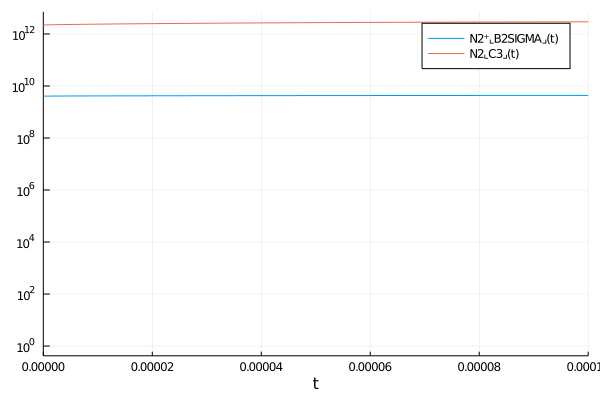

In [8]:
plot(sol, vars=(0, 22), yscale=:log10, ylims=[1,3e12])
plot!(sol, vars=(0, 6))

# Sensitivity analysis

Based on [DifferentialEquations tutorial](https://diffeq.sciml.ai/stable/analysis/global_sensitivity/)

In [9]:
f1 = function (p)
  params = (p .+ 0.5).*ps
  prob1 = remake(prob;p=params)
  sol = solve(prob1, Rodas4P();
              saveat=range(2.0*tspan[2]/3.0, stop=tspan[2], length=100),
              reltol=1e-4,
              abstol=1e-4,
             )
  params[106]*mean(sol[22,:])/(mean(sol[6,:]))/params[105]
end

bounds = [ [0., 1.] for _ in ps ]
m = gsa(f1, Morris(
        total_num_trajectory=1000,
        num_trajectory=150,
        len_design_mat=length(ps)
        ), bounds)

DiffEqSensitivity.MorrisResult{Array{Float64,2},Array{Any,1}}([4.527589908675743e-6 1.644454077083327e-5 … -7.285743696615269e-13 3.916738874875542e-13], [4.716958416010469e-6 1.6640454057771156e-5 … 2.1714188570834852e-11 1.3206610059267979e-12], [2.1974269349007655e-11 2.1598065126533463e-10 … 2.1286567150167203e-21 1.370772489513239e-23], Any[[5.367728317641509e-6, 5.373009156104316e-6, 3.033222785274526e-6, 6.293117571899538e-6, 3.4013600738409606e-6, 1.0941148565843417e-5, 1.0951073473684335e-5, 1.0950586676927103e-5, 4.095041594756031e-6, 4.087216474350868e-6  …  1.7248807448449321e-6, 1.7566242018992613e-6, 5.794013833065485e-6, 3.0410450259832074e-6, 3.3226481002340057e-6, -4.143132468675831e-6, 1.1333212370025717e-6, 1.1223140109617776e-6, 7.877831620428473e-6, 7.857720241389701e-6], [5.6997932312476213e-5, 2.1558199302814774e-5, 2.1620416668894967e-5, 6.750874795563014e-6, 6.731359796998703e-6, 1.1758961320594314e-5, 1.3636384641700052e-5, 4.6074399594555686e-5, 1.64225540143

In [15]:
# output most significant reactions
inds = sortperm(map(x->x[1]^2 + x[2]^2, zip(m.means[1,:], m.variances[1, :])), rev=true)
for i in inds[1:9]
    r =  rs.eqs[i]
    f = x-> join(map(string, x), " + ")
    println("$(i): ", f(r.substrates), " => ", f(r.products), ":  μ = $(m.means[i]),  σ = $(m.variances[i])")
end

10: e(t) + N2(t) => e(t) + N2⌞C3⌟(t):  μ = -0.001553659575833033,  σ = 4.988805871200958e-6
105: N2⌞C3⌟(t) => N2⌞B3⌟(t):  μ = -0.0013090968307958837,  σ = 3.423558070388809e-6
28: e(t) + N2(t) => e(t) + N2⁺⌞B2SIGMA⌟(t):  μ = 0.0011505070634744048,  σ = 7.120897068336875e-7
106: N2⁺⌞B2SIGMA⌟(t) => N2⁺(t):  μ = 0.0011091536669011516,  σ = 6.63135683302409e-7
331: N2⁺⌞B2SIGMA⌟(t) + N2(t) => N2⁺(t) + N2(t):  μ = -0.0010993812556264286,  σ = 1.1693896471177194e-6
130: N2⌞C3⌟(t) + O2(t) => N2(t) + O(t) + O⌞1S⌟(t):  μ = 0.000990074921527317,  σ = 8.841992197390477e-7
129: N2⌞C3⌟(t) + N2(t) => N2⌞ã1⌟(t) + N2(t):  μ = 0.0002513052753926949,  σ = 6.367253084162134e-8
332: N2⁺⌞B2SIGMA⌟(t) + O2(t) => N2⁺(t) + O(t) + O⌞1S⌟(t):  μ = -0.00023099252115601232,  σ = 7.307662475312689e-8
283: O(t) + O2(t) + N2(t) => O3(t) + N2(t):  μ = -0.00023089541187563953,  σ = 6.392789515278414e-8


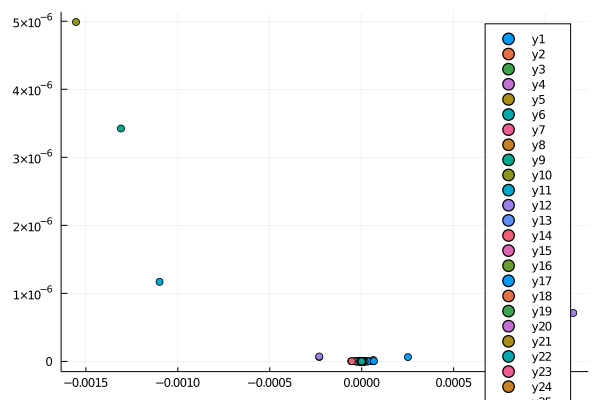

In [11]:
scatter(m.means, m.variances)